In [35]:
def res1_probability(filename):
    '''
    pseudo description of the function
    1. matching conditions and response type of a subject
    2. returning a Series which includes the number of each response type
    '''
    old=filename['Task_Type']==0
    new=filename['Task_Type']==1
    conditionlist = [
        (old) & (filename['Res1']==1),
        (old) & (filename['Res1']==2),
        (old) & (filename['Res1']==3),
        (old) & (filename['Res1']==4),
        (new) & (filename['Res1']==1),
        (new) & (filename['Res1']==2),
        (new) & (filename['Res1']==3),
        (new) & (filename['Res1']==4)]
    choicelist = ['HIT-HC', 'HIT-LC', 'MISS-LC', 'MISS-HC', 'FA-HC', 'FA-LC', 'CR-LC', 'CR-HC']
    filename['Res_Type'] = np.select(conditionlist, choicelist)
    old1=filename[filename['Task_Type']==0]
    new1=filename[filename['Task_Type']==1]
    type_probability_old = (old1.groupby(['Res_Type'])['Trial'].count())/len(old1)
    type_probability_new = (new1.groupby(['Res_Type'])['Trial'].count())/len(new1)
    type_probability=pd.concat([type_probability_old,type_probability_new])

    return type_probability

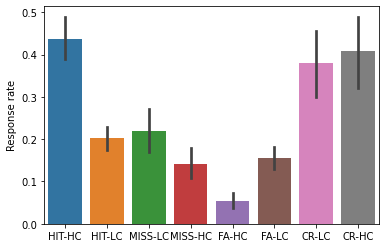

In [36]:
import pandas as pd
import numpy as np
import os

#Create an empty dataframe for making response type chart of 31 subjects
res_rate = pd.DataFrame(index=[
    'HIT-HC', 'HIT-LC', 'MISS-LC', 'MISS-HC','FA-HC', 'FA-LC', 'CR-LC', 'CR-HC'])
filelist=os.listdir('./DMdata')

for i in filelist:
    '''
    Addig data for each subject into the empty dataframe above
    '''
    file_path = pd.read_csv('./DMdata/{}/{}_test.txt'.format(i,i), sep='\t', index_col=False)
    res=res1_probability(file_path)
    res_rate['{}_test'.format(i)]=res
res_rate=res_rate.fillna(0).T

# Visualizing the created dataframe like following;
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(data=res_rate)
plt.ylabel('Response rate')
plt.show()

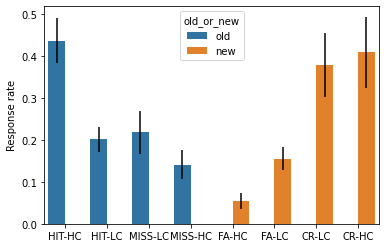

In [37]:
#Or, for adding legend(old and new) to the plot, you can manually type the error range
#Like following;
res_rate=res_rate.fillna(0).T
res_rate['old_or_new']=['old','old','old','old','new','new','new','new']
a = 1.96* res_rate.iloc[:,:31].std(axis=1)/31**(1/2)
sns.barplot(res_rate.index, res_rate.iloc[:,:31].mean(axis=1), yerr=a, hue=res_rate['old_or_new'])
plt.ylabel('Response rate')
plt.show()

In [38]:
def res2_probability(studyfile, testfile_original):
    '''
    1. Cleaning the testfile of an subject
    2. Merging the cleaned dataset with studyfile for 
    3. Cleaning the merged dataset, matching the condition and the location score
    (correct or wrong)
    4. Return Series of Location score, grouped by its location score and response type.
    '''
    testfile=testfile_original.copy()
    only_old = testfile.drop(testfile.loc[testfile['Res2']==0].index)
    only_old = pd.merge(studyfile, only_old, left_on= 'ObjID', right_on= 'Object_ID', how='left')
    only_old = only_old.drop(only_old.loc[only_old['Res2']==5].index)
    
    conditionlist = [
        (only_old['LocID']!=only_old['Res2']),
        (only_old['LocID']==only_old['Res2'])]
    choicelist = ['wrong', 'correct']
    only_old['Location_score'] = np.select(conditionlist, choicelist)
    
    only_old=only_old[['Location_score', 'Res_Type']]
    loc_probability = only_old.groupby(
        ['Location_score','Res_Type'])['Location_score'].count()/only_old.groupby(
        'Res_Type')['Location_score'].count()
    return loc_probability

In [39]:
import pandas as pd
import numpy as np
import os

#Create an empty dataframe for next progress
loc_rate = pd.DataFrame(index=[[
    'correct','correct','correct','correct','wrong','wrong','wrong','wrong'],[
    'HIT-HC','HIT-LC','MISS-LC','MISS-HC','HIT-HC','HIT-LC','MISS-LC','MISS-HC']])

filelist=os.listdir('./DMdata')
for i in filelist:
    '''
    Adjust the function to 31 subjects and put those data into the empty dataframe
    '''
    testing = pd.read_csv('./DMdata/{}/{}_test.txt'.format(i,i), sep='\t', index_col=False)
    studying = pd.read_csv('./DMdata/{}/{}_study.txt'.format(i,i), sep='\t', index_col=False)
    res1_probability(testing)
    res2=res2_probability(studying, testing)    
    loc_rate['{}_test'.format(i)]=res2

# Cleaning for better plot and renaming
loc_rate=loc_rate.fillna(0).T['correct']
loc_rate=loc_rate.rename({'HIT-HC':'HIT-HC&SRC','HIT-LC':'HIT-LC&SRC','MISS-LC':'MISS-LC&SRC','MISS-HC':'MISS-HC&SRC'},axis='columns')

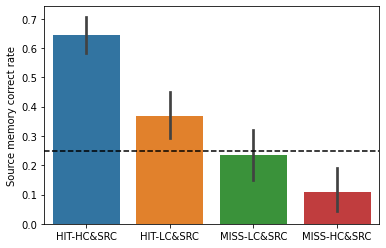

In [40]:
#Plotting
sns.barplot(data=loc_rate)
plt.ylabel('Source memory correct rate')
plt.axhline(y=0.25, color='black', linestyle='--')
plt.show()